# Novelty detection using 1-class SVM

Classifies new data as similar or different to the training set.  This method is an unsupervised method that builds a decision boundary between the data and origin in kernel space and can be used as a novelty detector.

In [1]:
%load_ext sql

In [2]:
# Greenplum Database 5.x on GCP (PM demo machine) - via tunnel
#%sql postgresql://gpadmin@localhost:8000/madlib
        
# PostgreSQL local
%sql postgresql://fmcquillan@localhost:5432/madlib

In [3]:
# Setup
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager

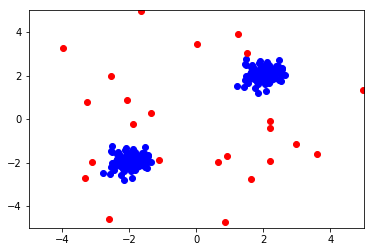

In [4]:
# Generate train data
X = 0.3 * np.random.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
X_train_D = pd.DataFrame(X_train, columns=['x1', 'x2'])

# Generate some abnormal novel observations
X_outliers = np.random.uniform(low=-7, high=7, size=(40, 2))
X_outliers_D = pd.DataFrame(X_outliers, columns=['x1', 'x2'])

b = plt.scatter(X_train[:, 0], X_train[:, 1], c='blue')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.show();

In [5]:
# Build tables
%sql DROP TABLE IF EXISTS X_train_D CASCADE;
%sql --persist X_train_D;
%sql ALTER TABLE X_train_D add column X float[];
%sql update X_train_D set X = array[x1, x2]::float[];

%sql DROP TABLE IF EXISTS X_outliers_D CASCADE;
%sql --persist X_outliers_D;
%sql ALTER TABLE X_outliers_D add column X float[];
%sql update X_outliers_D set X = array[x1, x2]::float[];

Done.


[]

'Persisted x_train_d'

Done.


[]

200 rows affected.


[]

Done.


[]

'Persisted x_outliers_d'

Done.


[]

40 rows affected.


[]

In [6]:
%%sql 
-- Train the model
DROP TABLE IF EXISTS svm_out1, svm_out1_summary, svm_out1_random CASCADE;
SELECT madlib.svm_one_class(
    'X_train_D',    -- source table
    'svm_out1',     -- output table
    'X',            -- features
    'gaussian',     -- kernel
    'gamma=1, n_components=55, random_state=3', 
    NULL,           -- grouping 
    'init_stepsize=0.1, lambda=10, max_iter=100, tolerance=0'  
    );
SELECT * FROM svm_out1; 

Done.
1 rows affected.
1 rows affected.


coef,loss,norm_of_gradient,num_iterations,num_rows_processed,num_rows_skipped,dep_var_mapping
"[-0.0633722302015402, -0.141681716745453, -0.771677402196372, 0.0867141599679751, -0.259877419688898, 0.111563986083496, 0.349476985188587, -0.752482251523658, 0.358467020942135, -0.921428832420919, 0.459881978831494, -0.0323041562234537, -0.116487872509266, -0.0670811003202482, -0.0753190700606155, -0.745637979983973, -0.0236219363888805, -0.900940846704358, -0.696129912166835, -0.54111261957129, -0.12669690252016, -0.216710697335916, -0.671910263179922, -0.250662229174146, -0.32784291725979, -0.13818300357978, 0.36065876191331, 0.468635432850185, 0.576830871723013, -0.26809306654817, -0.130256365759965, 0.304327237596594, -0.0351794790535994, 0.523537943974513, 0.446162405351283, 0.359675328061845, 0.0195378131670849, -0.0863329268693825, -0.590248807799436, -0.1114277288906, 0.656112036145448, 0.173468340481775, 0.507965441963636, 0.569369433122324, 0.147070932256151, 0.345877051092934, -0.0444530313128801, 0.0958483939810158, 0.673061845880972, 0.730479842894107, -0.220198940867896, -0.160510847505651, 0.285530718822088, -0.261899085081425, -0.54628139896305, -1.00015520604516]",0.383390108058,112.763105293,100,201,-1,"[-1.0, 1.0]"


In [7]:
# Prediction
# First for the training data
%sql drop table if exists y_pred_train;
%sql SELECT madlib.svm_predict('svm_out1', 'X_train_D', 'index', 'y_pred_train');
y_pred_train = %sql SELECT * from y_pred_train; 

# Next for the outliers
%sql drop table if exists y_pred_outliers;
%sql SELECT madlib.svm_predict('svm_out1', 'X_outliers_D', 'index', 'y_pred_outliers');
y_pred_outliers = %sql SELECT * from y_pred_outliers; 

#%sql SELECT * FROM y_pred_outliers limit 20; -- Show the outliers
%sql SELECT * FROM y_pred_train limit 20; 

Done.


[]

1 rows affected.


svm_predict
""


200 rows affected.
Done.


[]

1 rows affected.


svm_predict
""


40 rows affected.
20 rows affected.


index,prediction,decision_function
0,1.0,0.989953304307
1,1.0,1.17330218011
2,1.0,1.12268476523
3,1.0,0.357431258508
4,1.0,1.1803515073
5,1.0,1.0249236495
6,1.0,0.930264148315
7,1.0,0.764912118961
8,1.0,0.980942316141
9,1.0,0.821454375458


In [8]:
# Predict over the decision grid for plotting
# xx, yy = np.meshgrid(np.linspace(-7, 7, 500), np.linspace(-7, 7, 500))
xx, yy = np.meshgrid(np.linspace(-7, 7, 100), np.linspace(-7, 7, 100))
grid_points = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=['x1', 'x2'])

%sql DROP TABLE IF EXISTS grid_points CASCADE;
%sql --persist grid_points
%sql ALTER TABLE grid_points add column X float[]
%sql update grid_points set X = array[x1, x2]::float[]

Done.


[]

'Persisted grid_points'

Done.


[]

10000 rows affected.


[]

Done.
1 rows affected.
10000 rows affected.


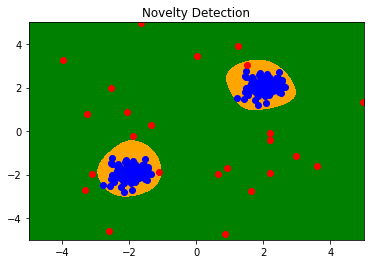

In [9]:
# Plot the decision grid
%sql drop table if exists Z_D;
%sql SELECT madlib.svm_predict('svm_out1', 'grid_points', 'index', 'Z_D');
Z_D = %sql SELECT decision_function from Z_D order by index
Z = np.array(Z_D)
Z = Z.reshape(xx.shape)

# Orange is not novel, green is novel
plt.title("Novelty Detection")
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='orange')
plt.contourf(xx, yy, Z, levels=[Z.min(), 0], colors='green')
#plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), Z.max(), 7), cmap=plt.cm.Blues_r)
b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='blue')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.show();